# Chapter 3: Supervised Learning

In this chapter we will used the Earth Engine techniques from earlier chapters to train a neural network in a simple classification task. This will involve two steps. First, we will automate the download and labeling tasks. Second, we will design, train, and evaluate a neural network using TensorFlow.

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import ee, scipy.misc, random, os
import numpy as np

# GEE stuff
from gee_library import *
ee.Initialize()

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Multi threading
import time
from threading import Thread

# Machine learning
import tensorflow as tf
from scipy import misc



# Generating testing and training data

Neural networks require huge amounts of data to be effective; a supervised classifier will require that all that data be *labeled* as well. Since labeling that much data would be require a huge amount of work for a human to accomplish, we will automate the task.

Our neural network will be trained to classify imagery as one of three classes: farmland, mountains, a city. Defining our classes this way allows us to automate the labeling process; we only have to know the gps bounds of a city and every tile we grab from that area can be labeled "city."

The next section will walk though a simple automated-imagery-downloader. It will save the images to your hard drive and generate a CSV file that indexes each image with its label. (The pattern of flat images with label files is common for computer vision datasets.) In this chapeter we will leave the images as flat files and feed them directly into the neural network. The next chapter will look into encapsulating them into a more efficient data structure.

In [2]:
#
# Define where we will save the data. 
#
DATA_DIR="data/ch3"
TRAIN_IMG_DIR=os.path.join(DATA_DIR, "train_imgs")
TRAIN_IMG_LABELS=os.path.join(DATA_DIR, "train.txt")
TEST_IMG_DIR=os.path.join(DATA_DIR, "test_imgs")
TEST_IMG_LABELS=os.path.join(DATA_DIR, "test.txt")


#
# We will define areas to grab imagery from. When selecting these areas we
# had to be careful that they were large enough that taking random selections from
# them wouldn't result in repeated images. 
#

# Cities
brooklyn= ((-73.965471, 40.614974), (-73.920207, 40.693991))
longisland= ((-73.918610, 40.713007), (-73.840551, 40.775980))
queens= ((-73.821792, 40.749724), (-73.760813, 40.780303))
sf1= ((-122.453085, 37.719024), (-122.394265, 37.789567))
sanjose= ((-122.033408, 37.243222), (-121.832452, 37.414198))
sandiego= ((-117.144966, 32.743224), (-117.098079, 32.761772))
sandiego2= ((-117.098079, 32.690284), (-117.021168, 32.743224))
denver= ((-105.127158, 39.569603), (-104.890206, 39.825191))
neworleans= ((-90.229627, 29.967342), (-90.034561, 30.016651))
baltimore= ((-76.651899, 39.287861), (-76.609940, 39.311176))
# Farmland
kentucky= ((-84.479444, 38.110622), (-84.335569, 38.258371))
kansas= ((-97.533941, 38.105647), (-96.815051, 38.366043))
montana= ((-108.994821, 45.875502), (-108.770538, 46.105918))
california= ((-121.789047, 38.223409), (-121.575699, 38.473852))
virginia= ((-76.838359, 36.483186), (-76.609497, 36.684365))
# Mountains
cascades = ((-121.575448, 48.224966), (-120.395554, 48.955637))
# bc = ((-126.871931, 50.727633), (-122.548457, 51.421085))
sierranevadas = ((-120.479266, 38.206113), (-120.198767, 39.346931))
yellowstone = ((-110.042831, 43.716602), (-109.379713, 44.437358))
rockies = ((-106.790375, 38.610576), (-106.352140, 39.315902))
rockies2 = ((-107.872873, 37.627164), (-106.433726, 38.047526))
# jasper = ((-118.961940, 51.490493), (-116.910005, 52.873976))
yosemite = ((-119.956063, 37.535445), (-119.282902, 38.176927))

#
# Now we separate the areas into test and training sets. This separation is very important!
# Evaluating a statistical model using the same data you trained it on can lead to overfitting
# and poor real-world results.
#
# We're being extra-careful here by including completely different areas in the test and training
# sets. Our downloader is fairly unsophisticated and simply grabs random samples from each area;
# there is a chance that the some images might overlap. We also wanted to make sure that the
# classifier will be able to generalize to new cities not yet seen.
#

training_cities = [brooklyn, longisland, queens, sf1, sanjose, sandiego, sandiego2]
test_cities = [baltimore, neworleans]

training_mountains = [cascades, sierranevadas, yellowstone, rockies]
test_mountains=[yosemite, rockies2]

training_farms=[montana, kansas, kentucky]
test_farms=[virginia, california]
    

In [3]:


def download_data(gps_bound_list, number_of_examples, directory, delay=2):
    """
    Downloads random tiles from a list of regions to `directory`. This function only downloads
    the images; it does not generate the CSV file. 
    
    The process of querying the server for a download URL and then downloading and unzipping the
    images takes several seconds per image. We can work on multiple images at once by spawning a
    separate thread for each image request. This function shows a simple approach to multi-threading.

    Google Earth Engine limits the number of requests that an individual can make. If too many images
    are resulting in 429 ServerErrors, try increasing the delay.
    
    gps_bound_list   (List): list of gps coordinates. For example:
            [ ((-73.965, 40.614), (-73.920, 40.693)),
              ((-105.127, 39.569), (-104.890, 39.825)) ]
    number_of_examples(int): The number of images that will be downloaded.
    directory      (string): Images will be saved to this directory.
    delay             (int): The delay between requests, in seconds.
    """
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for i in range(number_of_examples):
        if i%100 == 0:
            print i
        t = Thread(target=save_random_tile_at,
                   args=(random.choice(gps_bound_list),
                         600,
                         50,
                         ['R', 'G', 'B'],
                         os.path.join(directory, str(i)+'.png')))
        t.start()
        time.sleep(delay)


def save_random_tile_at(coords, meters, pixels, bands, file_name):
    """
    Saves a random (pixels x pixels) image from the region described by coords.
    The image will be saved to disk at file_name.
    
    coords: Two gps points describing a rectangle in the form:
        ((longitude_min, latitude_min),(longitude_max, latitude_max))
    meters: Each image will depict and area measuring meters x meters 
    pixels: Each image will measure pixels x pixels
    bands: List of requested bands. For example: ['R', 'G', 'B']
    file_name: File path where the image should be saved at. For example "./tmp/IMG0293.png"

    """
    try:
        # Get random location in box
        ((longmin, latmin),(longmax, latmax)) = coords

        # get random coords
        longitude = random.uniform(longmin, longmax)
        latitude = random.uniform(latmin, latmax)

        # Calculate resolution
        resolution = meters/pixels

        # Build the GPS box Geometry object
        tile_bounds = square_centered_at(
            point = (longitude, latitude),
            half_distance = meters / 2
        )

        # load image collection
        monterey_collection = ee.ImageCollection('USDA/NAIP/DOQQ')\
            .filterBounds(tile_bounds)

        # request imagery
        tiles = img_at_region(monterey_collection, resolution, bands, tile_bounds)

        # resize img to requested size
        np_band_array = [scipy.misc.imresize(tiles[b], (pixels, pixels)) for b in bands]

        # and stack the images in a matrix
        img = np.dstack(np_band_array)
        
        # make sure the image isn't a blank image (some times this happens if you get the coordinates
        # wrong and point to an area not covered.)
        if np.mean(img) == 0:
            raise Exception("Blank image detected.")

        # Save image to file
        scipy.misc.toimage(img, cmin=0.0, cmax=-1).save(file_name)
        
    #
    # Error Handling
    #
    except ServerError as e:
        print e, file_name, coords
    except Exception as e:
        print e, file_name, coords
    return
    

In [4]:
#
# Now we'll use all the functions and lists we made to download all of our data.
# Keep in mind this is a long process and will take several hours. You can
# expediate the process by reducing the number of examples (but you may get worse results.)
#

#
# Download training data
#
number_per_training_class = 2000
print 'Grabbing training farms...'
# download_data(training_farms, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'farms'))
print 'Grabbing training cities...'
# download_data(training_cities, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'cities'))
print 'Grabbing training mountains...'
download_data(training_mountains, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'mountains'))


#
# Download test data
#
number_per_test_class = 500
print 'Grabbing testing farms...'
# download_data(test_farms, number_per_test_class, os.path.join(TEST_IMG_DIR,'farms'))
print 'Grabbing testing cities...'
# download_data(test_cities, number_per_test_class, os.path.join(TEST_IMG_DIR,'cities'))
print 'Grabbing testing mountains...'
download_data(test_mountains, number_per_test_class, os.path.join(TEST_IMG_DIR,'mountains'))
        

Grabbing training farms...
Grabbing training cities...
Grabbing training mountains...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Status code 429 ./ch3_data/train_imgs/mountains/1269.png ((-110.042831, 43.716602), (-109.379713, 44.437358))
1300
1400
1500
1600
1700
1800
1900
Grabbing testing farms...
Grabbing testing cities...
Grabbing testing mountains...
0
100
200
300
400


In [5]:
#
# Populate label files as comma-separated values (CSV).
# We could have done this step at the same time we downloaded the files, but multiple
# threads writing to the same file can be complicated to do right. Instead, we downloaded
# each class of image to a separate directory. Since we know the label for each image in
# a directory, we can generate the CSV file here.
#

# Training Data
with open(TRAIN_IMG_LABELS, "w") as myfile:
    klass = 0   # 'class' is a reserved keyword in Python.
    path = os.path.join(TRAIN_IMG_DIR,'farms')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
            
    klass = 1
    path = os.path.join(TRAIN_IMG_DIR,'cities')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
        
    klass = 2
    path = os.path.join(TRAIN_IMG_DIR,'mountains')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
        

# Test Data
with open(TEST_IMG_LABELS, "w") as myfile:
    klass = 0
    path = os.path.join(TEST_IMG_DIR,'farms')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
            
    klass = 1
    path = os.path.join(TEST_IMG_DIR,'cities')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
        
    klass = 2
    path = os.path.join(TEST_IMG_DIR,'mountains')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")

# Machine Learning

Now that we have downloaded all of our imagery, we can design, train, and evaluate a simple convolutional neural network to classify them.

This section will assume that you know the general vocabulary of neural networks and statistics, but not TensorFlow. The math underpining neural networks is an entire field in itself and can't be covered here. If you're interested in learning the science, Stanford makes its excellent CS231n available online for free: https://cs231n.github.io/. If that course is a bit too advance, Andrew Ng's Machine Learning course on Coursera is a very good introduction to Machine Learning in general.

In [6]:
#
# Model
#


#
# By convention, x is used to refer to the input to a statistical model
# and y refers to the model's output. Since this is supervised learning
# we must provide labels for the data. These labels can be thought of
# as the "correct answers." We will use y_ to describe these.
#
# Placeholders are variables in a TensorFlow model that a user must fill
# before training or testing the model. (We will provided values for these
# place hodlers later.)
#
# Keep in mind that TensorFlow works using a concept it calls 'defered execution.'
# This means that as we call functions like tf.reshape() and tf.multiply(), no
# computations are actually happening yet. Tensorflow records the operations and
# connections we make in this section and executes them noly when we train and then test
# the network later.
#

# Our input images will be a 50x50x3 image flattened into a vector
x = tf.placeholder(tf.float32, [None, 50*50*3])
# The answers will be given as a one-hot-array. This is an array where exactly one
# element is 1 and the rest are zeros. For example: [0,1,0]
y_ = tf.placeholder(tf.float32, [None, 3])
# The training placeholder will allow us to turn on and off certain network features
# like dropout and batch normalization
training = tf.placeholder(tf.bool)


input_norm = tf.contrib.layers.batch_norm(x, 
                                  center=True, scale=True, 
                                  is_training=training)


# Since we are using a convolutional neural network we must convert the flattened image
# into a proper image shape.
input_layer = tf.reshape(input_norm, [-1, 50, 50, 3])




#
# Convolution and Pooling Layers
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
# pool1_norm = tf.contrib.layers.batch_norm(pool1, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
# pool2_norm = tf.contrib.layers.batch_norm(pool2, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #3 (no pooling)
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
# conv3_norm = tf.contrib.layers.batch_norm(conv3, center=True, scale=True, activation=tf.nn.relu, is_training=training)


#
# Fully Connected Layers
#


# Dense Layer
conv3_flat = tf.reshape(conv3, [-1, 9 * 9 * 64])
fc1 = tf.layers.dense(inputs=conv3_flat, units=1024, activation=tf.nn.relu)
# fc1_norm = tf.contrib.layers.batch_norm(fc1, center=True, scale=True, activation=tf.nn.relu, is_training=training)
dropout = tf.layers.dropout(
    inputs=fc1,
    rate=0.6,
    training= True)

# Model Output. We want this to be a one-hot array.
y = tf.layers.dense(inputs=dropout, units=3)



#
# The loss function, sometimes called a cost function, measures how good the network's
# answer compares to the correct answer. A lower loss means a better answer.
# A good loss function smoothly approaches zero as two answers approach each other.
# 'Softmax' refers to the process of turing the y array, which could contain any values,
# into a matrix where all the elements sum to 1. Since every image belongs only to one class,
# this makes sense.
# We will be using a common classifier loss function: the cross-entropy loss. It's not
# too important to know how it works right now.
#

loss = None
train_op = None

loss = tf.losses.softmax_cross_entropy(
    onehot_labels=y_, # ground truth
    logits=y) # network output

#
# Here we define an accuracy function so that we can have some
# visibility into how well our model is learning. This is used during
# the training step.
#
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# We'll also calculate the softmax of the output for easier predictions
y_softmax = tf.nn.softmax(y)

In [7]:
#
# It is common to train a neural network on "batches" of images. This creates
# smoother gradients and expedites learning. To batch images we will stack 3-dimentional
# images (width x height x channels) in the fourth dimention to create a 4-dimentional tensor
# with the dimentions (batch_size x height x width x channels)
#
# We'll define a function to batch images for us, which we will use in the next section.
#

def gee_batch(data_label_file, batch_size):
    """
    Generates image batches.
    
    data_label_file: File path of CSV file detailing filenames and labels
    batch_size: Number of images to stack
    """
    
    # read CSV file
    lines = open(data_label_file).read().splitlines()
    
    img_list = []
    label_list = []
    for i in range(batch_size):
        # Choose a random image from the dataset
        png_path, label = random.choice(lines).split(',')
        # Load the image
        img_list.append(misc.imread(png_path).flatten())
        # And generate a one-hot array for the label
        one_hot = np.zeros(3)
        one_hot[int(label)] = 1
        label_list.append(one_hot)
        
    return np.stack(img_list, axis=0), np.stack(label_list, axis=0)

In [8]:
#
# Training
#
# Now we'll train the network. All the operations we defined earlier will be
# executed in this section. If you're using a CPU for calculations (which you
# probably are) this section could take several hours, even for the few thousand
# iterations. If you see loss flatten out, though, you can halt the kernel and
# continue to to the next cell for evaluation.
# (A note on GPUs: Tensorflow only support NVIDIA GPUs right now, so even if you
# have a GPU you might not be able to use it. If you do have an NVIDIA GPU you'll
# have to recompile Tensorflow with the CUDA drivers. That process won't be
# covered here.)
# 


# The 'optimizer' is the algorithm we will use to minimize the cost function.
# This is a surprisingly complex issue with many approaches, although Adam
# is a good default.
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Required for batch norm
with tf.control_dependencies(update_ops): # Required for batch norm
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 1e-4
    learning_rate = tf.train.exponential_decay(learning_rate = starter_learning_rate,
                                               global_step = global_step,
                                               decay_steps = 100,
                                               decay_rate = 0.96,
                                               staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)


# Initialize TensorFlow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


# And run 20k iterations
for i in range(12000):
    # Load a batch of images
    example_batch, label_batch = gee_batch(TRAIN_IMG_LABELS, 128)
    
    # Every 100 iterations we evaluate how well the network is performing. We're using
    # the test set to display loss and accuracy; expect performance on the test
    # set to be worse.
    if i%100 == 0:
        train_accuracy, loss_out, lr = sess.run( fetches = [model_accuracy, loss, learning_rate],
                                       feed_dict={x : example_batch,
                                                  y_: label_batch,
                                                  training: False})
        print "Step", i, "Loss:", loss_out, "Accuracy:", train_accuracy, "LR:", lr
        
    # run an iteration
    optimizer.run(feed_dict={x:example_batch,
                             y_: label_batch,
                             training: True})


Step 0 Loss: 30.7566 Accuracy: 0.328125 LR: 0.0001
Step 100 Loss: 11.312 Accuracy: 0.46875 LR: 9.6e-05
Step 200 Loss: 7.03179 Accuracy: 0.4375 LR: 9.216e-05
Step 300 Loss: 7.87562 Accuracy: 0.476562 LR: 8.84736e-05
Step 400 Loss: 5.31416 Accuracy: 0.46875 LR: 8.49346e-05
Step 500 Loss: 4.84675 Accuracy: 0.414062 LR: 8.15373e-05
Step 600 Loss: 4.0106 Accuracy: 0.554688 LR: 7.82758e-05
Step 700 Loss: 2.61514 Accuracy: 0.601562 LR: 7.51447e-05
Step 800 Loss: 2.68239 Accuracy: 0.59375 LR: 7.21389e-05
Step 900 Loss: 2.38447 Accuracy: 0.632812 LR: 6.92534e-05
Step 1000 Loss: 1.36465 Accuracy: 0.726562 LR: 6.64832e-05
Step 1100 Loss: 1.63842 Accuracy: 0.65625 LR: 6.38239e-05
Step 1200 Loss: 1.4228 Accuracy: 0.679688 LR: 6.1271e-05
Step 1300 Loss: 0.88696 Accuracy: 0.757812 LR: 5.88201e-05
Step 1400 Loss: 0.829078 Accuracy: 0.695312 LR: 5.64673e-05
Step 1500 Loss: 0.649436 Accuracy: 0.804688 LR: 5.42086e-05
Step 1600 Loss: 0.548211 Accuracy: 0.804688 LR: 5.20403e-05
Step 1700 Loss: 0.480668 Ac

In [9]:
#
# Evaluation
# 
# Now we will evaluate the performance of the network by measuring the accuracy on a batch of
# images from the test set.
#
# I get about 52% accuracy, which is pretty poor (but better than random, which would be 33%.)
# See if you can do better!
#

example_batch, label_batch = gee_batch(TEST_IMG_LABELS, 256)

train_accuracy = sess.run( fetches = [model_accuracy],
                                     feed_dict={x : example_batch,
                                                y_: label_batch,
                                                training: False})


print "Accuracy in the test set:", train_accuracy

Accuracy in the test set: [0.52734375]


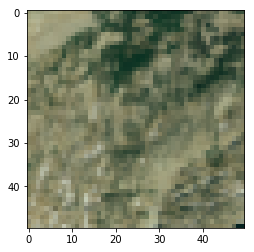

predictions: [0.0, 0.4321, 0.5679]
ground truth: [ 0.  0.  1.]


In [16]:
#
# Prediction
#
# Now we will use the model to predict the class of some images from the test set.
# We'll keep the one-hot array encoding for the labels so that you can see the network's
# output. Higher predicted values mean that the network is more confident that the image
# belongs to that class.
# As a reminder, the classes are:
# farm:     0  one-hot: [1,0,0]
# city:     1  one-hot: [0,1,0]
# mountain: 2  one-hot: [0,0,1]
#
# You can keep rerunning this cell to test more images (CTRL-Enter runs the selected cell.)


example_batch, label_batch = gee_batch(TEST_IMG_LABELS, 1)

groundtruth, predicted = sess.run(   fetches = [y_, y_softmax],
                                     feed_dict={x : example_batch,
                                                y_: label_batch,
                                                training: False})


img = example_batch.reshape((50,50,3))
plt.imshow(img); plt.show()

print "predictions:", [ round(elem, 4) for elem in predicted[0] ]
print "ground truth:", groundtruth[0]